##### <h1><center>Applying Data Science to Compare the Neighborhoods of New York and Toronto</center></h1>
<h2><center>G. G. C. M. Gunasekara</center></h2>
<h2><center>February 15, 2020</center></h2>

Lets download and import all the libraries we need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## Download and Cleaning Datasets

### First create dataframe for New York

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

all the relevant data is in *features* key 

In [3]:
NYK_data = newyork_data['features']
## Transform data into pandas dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NYK = pd.DataFrame(columns=column_names)

In [4]:
for data in NYK_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYK = NYK.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
print("== New York Data Set ==")
NYK.head()

== New York Data Set ==


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
NYK['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

### Creating Dataframe of Toronto

First scrap the table from wiki

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' #url to the wiki site
list_of_dataframes = pd.read_html(url) #get the list of data_frames from website
Toronto_data = list_of_dataframes[0] #we just want the first dataframe

In [8]:
Toronto_data.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [9]:
## drop raws where Borough is "Not assigned"
Toronto_data.drop(Toronto_data[Toronto_data['Borough']=="Not assigned"].index, axis=0, inplace=True)

In [10]:
## group Borough and Neighbourhood against unique Postcode and combine
s1 = Toronto_data.groupby('Postcode')['Neighbourhood'].unique()
s2 = Toronto_data.groupby('Postcode')['Borough'].unique()
df_Toro = pd.concat([s2, s1], axis=1).reset_index()
df_Toro.head()

,Postcode,Borough,Neighbourhood
0,M1B,[Scarborough],"[Rouge, Malvern]"
1,M1C,[Scarborough],"[Highland Creek, Rouge Hill, Port Union]"
2,M1E,[Scarborough],"[Guildwood, Morningside, West Hill]"
3,M1G,[Scarborough],[Woburn]
4,M1H,[Scarborough],[Cedarbrae]


In [11]:
## apply below lambda function to 'Brough' and 'Neighbourhood' to make each element to a string
df_Toro['Borough']=df_Toro['Borough'].apply(lambda x: ','.join(map(str,x)))
df_Toro['Neighbourhood']=df_Toro['Neighbourhood'].apply(lambda x: ','.join(map(str,x)))

In [12]:
df_Toro.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [13]:
# download and load location data
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
## merge two dataframes to create final Toronto dataframe
Toro = df_Toro.merge(df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postcode','Postal Code'], axis=1)

In [14]:
print("== Toronto Data Set ==")
Toro.head()

== Toronto Data Set ==


,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
print("== New York Data Set ==")
NYK.head()

== New York Data Set ==


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Now we have obtain Neighborhood dataframes for New York and Toronto both

NYK --> New York DataFrame  
Toro --> Toronto DataFrame

In [16]:
print ("New York Dataframe shape",NYK.shape)
print ("Toronto Dataframe shape", Toro.shape)

New York Dataframe shape (306, 4)
Toronto Dataframe shape (103, 4)


## Let's view the distribution of Neighborhoods in each city on a map

In [17]:
map_NYK = folium.Map(location=[40.666256, -73.889939], zoom_start=11)

# add markers to the map
for lat, lon, poi in zip(NYK['Latitude'], NYK['Longitude'], NYK['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7).add_to(map_NYK)
       
map_NYK

In [18]:
map_Toro = folium.Map(location=[43.663573, -79.388711], zoom_start=11)

# add markers to the map
for lat, lon, poi in zip(Toro['Latitude'], Toro['Longitude'], Toro['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='lake',
        fill_opacity=0.7).add_to(map_Toro)
       
map_Toro

## Now let's explore veunes surrounded by each neighbourhood

### Define Foursquare credintionals

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
def getNearbyVenues(city, names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now create 2 dataframes with venue data of New York and Toronto

In [21]:
lat=40.890834
lng=-73.905643
radius=500
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

In [22]:
#requests.get(url).json()#["response"]['groups'][0]['items']

In [23]:
NYK.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [24]:
NYK_venues = getNearbyVenues(city='NYK', 
                                   names=NYK['Neighborhood'],
                                   latitudes=NYK['Latitude'],
                                   longitudes=NYK['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [25]:
#Toronto venues
Toro_venues = getNearbyVenues(city='Toro', 
                                   names=Toro['Neighbourhood'],
                                   latitudes=Toro['Latitude'],
                                   longitudes=Toro['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [26]:
Toro_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toro,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Toro,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,Toro,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,Toro,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Toro,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [27]:
Toro_venues.shape

(2206, 8)

In [28]:
NYK_venues.shape

(10248, 8)

In [29]:
NYK_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NYK,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,NYK,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,NYK,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,NYK,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,NYK,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant


In [30]:
Toro_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toro,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Toro,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,Toro,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,Toro,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Toro,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


## Exploratory Data Analysis

### finding common venue categories of both cities

In [31]:
#finding common venue categories of both cities

NYK_common_Top=NYK_venues['Venue Category'].value_counts()[:10]
Toro_common_Top=Toro_venues['Venue Category'].value_counts()[:10]

In [32]:
NYK_common_Top

Pizza Place            436
Italian Restaurant     311
Coffee Shop            294
Deli / Bodega          269
Bakery                 228
Bar                    220
Chinese Restaurant     218
Sandwich Place         186
Mexican Restaurant     178
American Restaurant    173
Name: Venue Category, dtype: int64

Plot the categories

Text(0.5, 1.0, 'Top most common venues in New York')

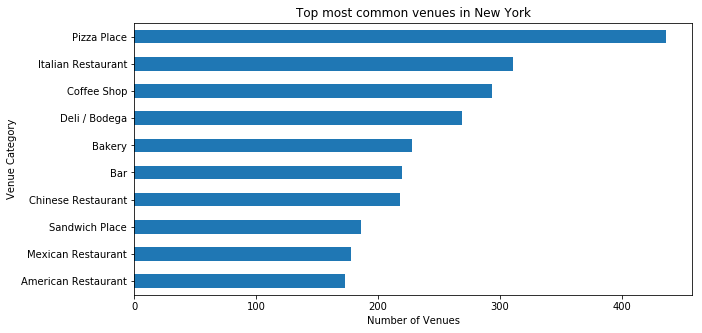

In [33]:
#%matplotlib inline

#NYK_common_Top.sort_values().plot(kind='barh', color='c', figsize=(10,5))
#plt.plot(kind='barh', color='c', figsize=(10,5), data=NYK_common_Top)
NYK_common_Top.sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of Venues")
plt.ylabel("Venue Category")
plt.title("Top most common venues in New York")

Text(0.5, 1.0, 'Top most common venues in Toronto')

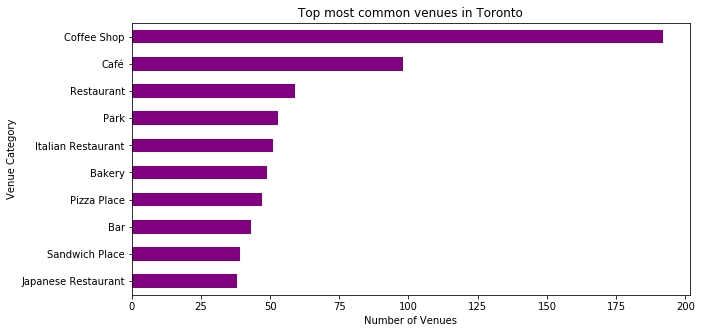

In [34]:
Toro_common_Top.sort_values().plot(kind='barh', color='purple', figsize=(10,5))
plt.xlabel("Number of Venues")
plt.ylabel("Venue Category")
plt.title("Top most common venues in Toronto")

In [35]:
NYK_venue_spread=NYK_venues.groupby(['Venue Category'])['Neighborhood'].nunique().sort_values(ascending=False)[:10]

In [36]:
Toro_venue_spread=Toro_venues.groupby(['Venue Category'])['Neighborhood'].nunique().sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Top most widespread venues in New York')

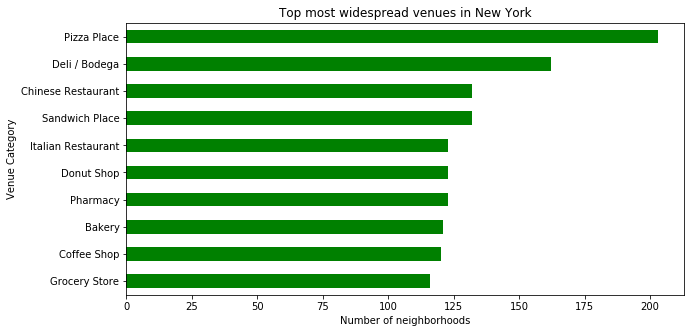

In [37]:
NYK_venue_spread.sort_values().plot(kind='barh', figsize=(10,5), color='g')
plt.xlabel("Number of neighborhoods")
plt.title("Top most widespread venues in New York")

Text(0.5, 1.0, 'Top most widespread venues in Toronto')

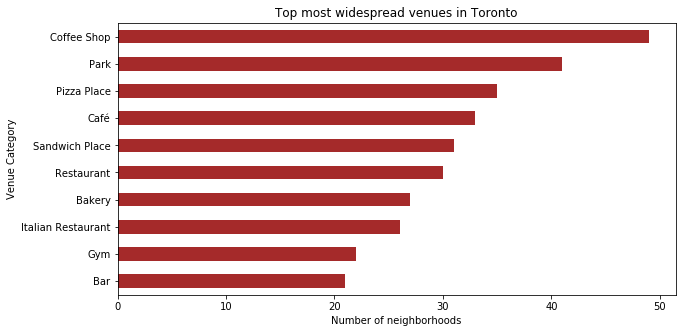

In [38]:
Toro_venue_spread.sort_values().plot(kind='barh', figsize=(10,5), color='brown')
plt.xlabel("Number of neighborhoods")
plt.title("Top most widespread venues in Toronto")

### Finding common Venue Categories in both cities and combine two dataframes

Before continue, we need to find venue categories that are common to both cities, so then we can compare two cities based on 
how many venues can be found in each category type.  
*Note:This will make feature set of both cities are the same*

In [39]:
s1 = NYK_venues['Venue Category'].value_counts() ## get different types of venues in New York

In [40]:
s2 = Toro_venues['Venue Category'].value_counts() ## get different types of venues in Toronto

In [41]:
print ("New York has {} number of unique venues where as Toronto has {} number of unique venues".format(s1.shape[0],s2.shape[0]))

New York has 431 number of unique venues where as Toronto has 263 number of unique venues


In [42]:
# Now let's get common venue categories to both cities
common_venues = list(set(s1.index) & set(s2.index))
print ("common venue categories in both cities:",len(common_venues)) ## count of common venue categories in both cities

common venue categories in both cities: 233


In [43]:
## Now let's reduce our dataframes so that only common venues are in each dataframe
NYK_venues = NYK_venues[NYK_venues['Venue Category'].isin(common_venues)] ## take raws where 'Venue Category' is in "common_venues"
Toro_venues = Toro_venues[Toro_venues['Venue Category'].isin(common_venues)]

In [44]:
NYK_venues['Venue Category'].value_counts().shape

(233,)

In [45]:
Toro_venues['Venue Category'].value_counts().shape

(233,)

In [46]:
print("New sizes of NYK_venues and Toro_venues dataframes \n NYK_venues : {} \n Toro_venues: {}".format(NYK_venues.shape,Toro_venues.shape))

New sizes of NYK_venues and Toro_venues dataframes 
 NYK_venues : (9256, 8) 
 Toro_venues: (2153, 8)


### Concatinate two cities dataframes so that we can cluster neighborhoods of both cities

In [47]:
Two_cities_venues = pd.concat([NYK_venues,Toro_venues], ignore_index=True)
Two_cities_venues.shape

(11409, 8)

In [48]:
print("shape of dataframes before and after concatinate")
print("NYK_venues :",NYK_venues.shape)
print("Toro_venues:",Toro_venues.shape)
print("Two_cities combined :",Two_cities_venues.shape)

shape of dataframes before and after concatinate
NYK_venues : (9256, 8)
Toro_venues: (2153, 8)
Two_cities combined : (11409, 8)


In [49]:
## function to create one hot encoded venue categories
def get_onehot(df_venues):
    # one hot encoding
    df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

    # add city and neighborhood columns back to dataframe
    df_onehot['City'] = df_venues['City'] 
    df_onehot['Neighbourhood'] = df_venues['Neighborhood'] 

    # move city and neighborhood column to the first column
    fixed_columns = [df_onehot.columns[-2], df_onehot.columns[-1]] + list(df_onehot.columns[:-2])
    df_onehot = df_onehot[fixed_columns]

    return (df_onehot)

In [50]:
## make onehot encoded dataframes
NYK_onehot=get_onehot(NYK_venues)
Toro_onehot=get_onehot(Toro_venues)
Two_cities_onehot=get_onehot(Two_cities_venues)

print("Shapes of each dataframe:")
print("NYK_onehot",NYK_onehot.shape)
print("Toro_onehot",Toro_onehot.shape)
print("Two_cities_onehot",Two_cities_onehot.shape)

Shapes of each dataframe:
NYK_onehot (9256, 235)
Toro_onehot (2153, 235)
Two_cities_onehot (11409, 235)


In [51]:
NYK_grouped = NYK_onehot.groupby(['City','Neighbourhood']).mean().reset_index()
Toro_grouped = Toro_onehot.groupby(['City','Neighbourhood']).mean().reset_index()
Two_cities_grouped = Two_cities_onehot.groupby(['City','Neighbourhood']).mean().reset_index()

print("Shapes of each dataframe:")
print("NYK_grouped:",NYK_grouped.shape)
print("Toro_grouped:",Toro_grouped.shape)
print("Two_cities_grouped:",Two_cities_grouped.shape)


Shapes of each dataframe:
NYK_grouped: (301, 235)
Toro_grouped: (100, 235)
Two_cities_grouped: (401, 235)


In [52]:
Two_cities_grouped.head()

,City,Neighbourhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,NYK,Allerton,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.066667,0.066667,0.033333,0.0,0.000000,0.033333,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0

### Get most 10 common venues of each neighborhood

A Neighborhood in the dataset has large number of venues/venue_categories. However, based on the fequency of the occuerence of each veneu in a perticular Neighborhood we can sort and find out most 10 common venues in each Neighborhood which will give us an understanding about which type of Neighborhood is this

In [53]:
## function to sort the venues in decending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
## function to return dataframe with top most common venues
def get_top_venues(venue_grouped, num_top_venues = 10):
    
    indicators = ['st', 'nd', 'rd']
    
    # create columns according to number of top venues
    columns = ['City','Neighbourhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    
    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['City'] = venue_grouped['City']
    neighborhoods_venues_sorted['Neighbourhood'] = venue_grouped['Neighbourhood']
    
    for ind in np.arange(venue_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)
    
    return(neighborhoods_venues_sorted)

In [55]:
NYK_venue_sorted=get_top_venues(NYK_grouped, num_top_venues=10)
Toro_venue_sorted=get_top_venues(Toro_grouped, num_top_venues=10)
Two_cities_venues_sorted=get_top_venues(Two_cities_grouped, num_top_venues=10)

print("Shapes of each dataframe:")
print("NYK_venue_sorted:",NYK_venue_sorted.shape)
print("Toro_venue_sorted:",Toro_venue_sorted.shape)
print("Two_cities_venues_sorted:",Two_cities_venues_sorted.shape)


Shapes of each dataframe:
NYK_venue_sorted: (301, 12)
Toro_venue_sorted: (100, 12)
Two_cities_venues_sorted: (401, 12)


In [56]:
Two_cities_venues_sorted.head()

,City,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NYK,Allerton,Pizza Place,Chinese Restaurant,Deli / Bodega,Department Store,Bus Station,Supermarket,Fried Chicken Joint,Pharmacy,Playground,Dessert Shop
1,NYK,Annadale,Liquor Store,Train Station,Sports Bar,Sushi Restaurant,Restaurant,Bakery,Pub,Deli / Bodega,Dance Studio,Diner
2,NYK,Arden Heights,Pizza Place,Pharmacy,Coffee Shop,Deli / Bodega,Bus Stop,Donut Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
3,NYK,Arlington,Bus Stop,Boat or Ferry,Intersection,Deli / Bodega,Coffee Shop,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio
4,NYK,Arrochar,Italian Restaurant,Pizza Place,Bus Stop,Deli / Bodega,Middle Eastern Restaurant,Supermarket,Sandwich Place,Food Truck,Bagel Shop,Mediterranean Restaurant


## Now Cluster Neighbourhood
Since feature set is common to both cities, we can apply clustering methods to identify common neighborhoods of both countries

Applying K-mean clustering algorhythem

In [57]:
Two_cities_grouped.head()

,City,Neighbourhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,NYK,Allerton,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.066667,0.066667,0.033333,0.0,0.000000,0.033333,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0

In [58]:
# set number of clusters
kclusters = 6

clustering = Two_cities_grouped.drop(['City','Neighbourhood'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 5, 5, 0, 0, 0, 0, 0, 0], dtype=int32)

In [59]:
#NYK.head()

In [60]:
#NYK.shape
#NYK_venue_sorted.shape

In [61]:
# add clustering labels
Two_cities_clustered = Two_cities_venues_sorted.loc[:]
Two_cities_clustered.insert(0, 'Cluster Labels', kmeans.labels_)


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#NYK_merged = NYK_merged.merge(NYK_clustered.set_index('Neighbourhood'), left_on='Neighborhood', right_on='Neighbourhood')

Two_cities_clustered.shape

(401, 13)

In [62]:
Two_cities_clustered['Cluster Labels'].value_counts()

0    356
5     14
3     13
1     10
4      5
2      3
Name: Cluster Labels, dtype: int64

In [63]:
Two_cities_clustered.head()

,Cluster Labels,City,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,NYK,Allerton,Pizza Place,Chinese Restaurant,Deli / Bodega,Department Store,Bus Station,Supermarket,Fried Chicken Joint,Pharmacy,Playground,Dessert Shop
1,0,NYK,Annadale,Liquor Store,Train Station,Sports Bar,Sushi Restaurant,Restaurant,Bakery,Pub,Deli / Bodega,Dance Studio,Diner
2,5,NYK,Arden Heights,Pizza Place,Pharmacy,Coffee Shop,Deli / Bodega,Bus Stop,Donut Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
3,5,NYK,Arlington,Bus Stop,Boat or Ferry,Intersection,Deli / Bodega,Coffee Shop,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio
4,0,NYK,Arrochar,Italian Restaurant,Pizza Place,Bus Stop,Deli / Bodega,Middle Eastern Restaurant,Supermarket,Sandwich Place,Food Truck,Bagel Shop,Mediterranean Restaurant


In [64]:
## Now let's split Two_cities_clustered dataframe for New York and Toronto seperately for the easyness of plotting
NYK_clustered = Two_cities_clustered[Two_cities_clustered['City']=="NYK"]
Toro_clustered = Two_cities_clustered[Two_cities_clustered['City']=="Toro"]
Toro_clustered.head()

,Cluster Labels,City,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
301,0,Toro,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Restaurant,Burger Joint,Bakery,Cosmetics Shop,Asian Restaurant
302,0,Toro,Agincourt,Breakfast Spot,Lounge,Skating Rink,Clothing Store,Latin American Restaurant,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Field,Fast Food Restaurant
303,2,Toro,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Playground,Park,Dog Run,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
304,0,Toro,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pizza Place,Sandwich Place,Pharmacy,Liquor Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Coffee Shop,Cupcake Shop
305,0,Toro,"Alderwood,Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pool,Pub,Sandwich Place,Pharmacy,Gym,Gluten-free Restaurant,Department Store


In [65]:
## we need to merge toronto_clustered with Toro to add latitude/longitude for each neighborhood

NYK_merged = NYK.merge(NYK_clustered.set_index('Neighbourhood'), left_on='Neighborhood', right_on='Neighbourhood')
Toro_merged = Toro.merge(Toro_clustered.set_index('Neighbourhood'), left_on='Neighbourhood', right_on='Neighbourhood')
Toro_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1,Toro,Fast Food Restaurant,Yoga Studio,Donut Shop,Fish & Chips Shop,Filipino Restaurant,Field,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Toro,Bar,Yoga Studio,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Toro,Pizza Place,Intersection,Rental Car Location,Electronics Store,Mexican Restaurant,Medical Center,Breakfast Spot,Spa,Gift Shop,Fast Food Restaurant
3,Scarborough,Woburn,43.770992,-79.216917,0,Toro,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
4,Scarborough,Cedarbrae,43.773136,-79.239476,0,Toro,Athletics & Sports,Fried Chicken Joint,Bank,Thai Restaurant,Bakery,Gas Station,Caribbean Restaurant,Falafel Restaurant,Event Space,Farmers Market


In [66]:
Two_cities_clustered.groupby('Cluster Labels')['City'].value_counts().unstack(level=1).reset_index()

City,Cluster Labels,NYK,Toro
0,0,274.0,82.0
1,1,7.0,3.0
2,2,1.0,2.0
3,3,3.0,10.0
4,4,2.0,3.0
5,5,14.0,NaN


In [67]:
# set number of clusters
for kclusters in range(6):
    if(kclusters==0 or kclusters==1): 
        continue
    clustering = Two_cities_grouped.drop(['City','Neighbourhood'], axis=1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)
    Two_cities_clustered = Two_cities_venues_sorted.loc[:]
    Two_cities_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
    print("K=",kclusters)
    print(Two_cities_clustered.groupby('Cluster Labels')['City'].value_counts().unstack(level=1),"\n")

K= 2
City            NYK  Toro
Cluster Labels           
0               293    87
1                 8    13 

K= 3
City            NYK  Toro
Cluster Labels           
0               295    88
1                 5     9
2                 1     3 

K= 4
City            NYK  Toro
Cluster Labels           
0               119    69
1                25     1
2                 4    11
3               153    19 

K= 5
City            NYK  Toro
Cluster Labels           
0               179    30
1               100    56
2                 5    11
3                 1     2
4                16     1 



In [68]:
kclusters

5

In [69]:
NYK_clustered = Two_cities_clustered[Two_cities_clustered['City']=="NYK"]
Toro_clustered = Two_cities_clustered[Two_cities_clustered['City']=="Toro"]
NYK_merged = NYK.merge(NYK_clustered.set_index('Neighbourhood'), left_on='Neighborhood', right_on='Neighbourhood')
Toro_merged = Toro.merge(Toro_clustered.set_index('Neighbourhood'), left_on='Neighbourhood', right_on='Neighbourhood')

In [70]:
Toro_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Toro,Fast Food Restaurant,Yoga Studio,Donut Shop,Fish & Chips Shop,Filipino Restaurant,Field,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1,Toro,Bar,Yoga Studio,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Toro,Pizza Place,Intersection,Rental Car Location,Electronics Store,Mexican Restaurant,Medical Center,Breakfast Spot,Spa,Gift Shop,Fast Food Restaurant
3,Scarborough,Woburn,43.770992,-79.216917,1,Toro,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
4,Scarborough,Cedarbrae,43.773136,-79.239476,0,Toro,Athletics & Sports,Fried Chicken Joint,Bank,Thai Restaurant,Bakery,Gas Station,Caribbean Restaurant,Falafel Restaurant,Event Space,Farmers Market


In [71]:
# create map
map_NYK = folium.Map(location=[40.666256, -73.889939], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYK_merged['Latitude'], NYK_merged['Longitude'], NYK_merged['Neighborhood'], NYK_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        text=cluster,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_NYK)
       
map_NYK

In [72]:
# create map for Toronto
map_Toro = folium.Map(location=[43.663573, -79.388711], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toro_merged['Latitude'], Toro_merged['Longitude'], Toro_merged['Neighbourhood'], Toro_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_Toro)
       
map_Toro

In [73]:
kclusters

5

## Cluster Analysis

For the sake of understanding each cluster generated by algorythem, we will find most common venues in each cluster

In [74]:
B={}
for clust_no in NYK_clustered['Cluster Labels'].value_counts().index:
    df=NYK_clustered[NYK_clustered['Cluster Labels']==clust_no].iloc[:,3:] #extract requied portion from the dataframe for each cluster number
    Items=[df.loc[i,j] for i in df.index for j in df.columns] #
    Freq={}
    for item in Items:
        Freq[item]=Items.count(item)
    #sort the venur, freq pairs based on freq and take first most 10
    Top_venue=sorted(Freq.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:10]
    b=pd.DataFrame(Top_venue)[0].to_list()
    B["Cluster" + str(clust_no)]=b
    
pd.DataFrame(B)

,Cluster0,Cluster1,Cluster4,Cluster2,Cluster3
0,Pizza Place,Coffee Shop,Bus Stop,Park,Fish & Chips Shop
1,Donut Shop,Italian Restaurant,Field,Yoga Studio,Filipino Restaurant
2,Deli / Bodega,Pizza Place,Fast Food Restaurant,Filipino Restaurant,Field
3,Chinese Restaurant,Bar,Farmers Market,Field,Fast Food Restaurant
4,Pharmacy,Café,Filipino Restaurant,Fast Food Restaurant,Farmers Market
5,Fast Food Restaurant,Bakery,Falafel Restaurant,Farmers Market,Falafel Restaurant
6,Sandwich Place,American Restaurant,Yoga Studio,Falafel Restaurant,Event Space
7,Bank,Deli / Bodega,Beach,Event Space,Ethiopian Restaurant
8,Supermarket,Park,Playground,Fish & Chips Shop,Donut Shop
9,Bakery,Mexican Restaurant,Fish & Chips Shop,Ethiopian Restaurant,Construction & Landscaping


In [75]:
C={}
for clust_no in Toro_clustered['Cluster Labels'].value_counts().index:
    df=Toro_clustered[Toro_clustered['Cluster Labels']==clust_no].iloc[:,3:] #extract requied portion from the dataframe for each cluster number
    Items=[df.loc[i,j] for i in df.index for j in df.columns] #
    Freq={}
    for item in Items:
        Freq[item]=Items.count(item)
    #sort the venur, freq pairs based on freq and take first most 10
    Top_venue=sorted(Freq.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:10]
    b=pd.DataFrame(Top_venue)[0].to_list()
    C["Cluster" + str(clust_no)]=b
    
pd.DataFrame(C)

,Cluster1,Cluster0,Cluster2,Cluster3,Cluster4
0,Coffee Shop,Fast Food Restaurant,Park,Fish & Chips Shop,Playground
1,Café,Field,Field,Filipino Restaurant,Fish & Chips Shop
2,Fast Food Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
3,Restaurant,Pizza Place,Farmers Market,Fast Food Restaurant,Field
4,Italian Restaurant,Falafel Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant
5,Yoga Studio,Event Space,Event Space,Drugstore,Farmers Market
6,Field,Yoga Studio,Filipino Restaurant,Construction & Landscaping,Falafel Restaurant
7,Farmers Market,Sandwich Place,Yoga Studio,Park,Event Space
8,Falafel Restaurant,Pharmacy,Dog Run,Falafel Restaurant,Ethiopian Restaurant
9,Bar,Park,Donut Shop,Event Space,Donut Shop


In [84]:
D={}
for clust_no in Two_cities_clustered['Cluster Labels'].value_counts().index:
    df=Two_cities_clustered[Two_cities_clustered['Cluster Labels']==clust_no].iloc[:,3:] #extract requied portion from the dataframe for each cluster number
    Items=[df.loc[i,j] for i in df.index for j in df.columns] #
    Freq={}
    for item in Items:
        Freq[item]=Items.count(item)
    #sort the venur, freq pairs based on freq and take first most 10
    Top_venue=sorted(Freq.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:10]
    total=len(Items)
    b=pd.DataFrame(Top_venue)[0].to_list()
    c=pd.DataFrame(Top_venue)[1].to_list()
    avg=[x/total*100 for x in c]
    D["Cluster" + str(clust_no)]=b
    D["Cluster" + str(clust_no) + " venues %"]=avg
    
pd.DataFrame(D)


,Cluster0,Cluster0 venues %,Cluster1,Cluster1 venues %,Cluster4,Cluster4 venues %,Cluster2,Cluster2 venues %,Cluster3,Cluster3 venues %
0,Pizza Place,5.550239,Coffee Shop,6.217949,Bus Stop,8.235294,Park,10.000,Fish & Chips Shop,10.000000
1,Donut Shop,3.971292,Italian Restaurant,4.679487,Field,7.058824,Field,9.375,Filipino Restaurant,10.000000
2,Fast Food Restaurant,3.875598,Café,3.846154,Fast Food Restaurant,7.058824,Fast Food Restaurant,9.375,Field,10.000000
3,Deli / Bodega,3.444976,Pizza Place,3.653846,Farmers Market,6.470588,Farmers Market,9.375,Fast Food Restaurant,10.000000
4,Pharmacy,3.253589,Bar,3.525641,Filipino Restaurant,5.294118,Falafel Restaurant,9.375,Farmers Market,10.000000
5,Sandwich Place,3.157895,Bakery,2.564103,Falafel Restaurant,5.294118,Filipino Restaurant,6.875,Construction & Landscaping,10.000000
6,Chinese Restaurant,3.157895,Yoga Studio,2.243590,Yoga Studio,3.529412,Event Space,6.875,Falafel Restaurant,6.666667
7,Bank,2.870813,Park,2.243590,Playground,3.529412,Yoga Studio,6.250,Event Space,6.666667
8,Bakery,2.200957,American Restaurant,2.179487,Fish & Chips Shop,3.529412,Donut Shop,4.375,Drugstore,6.666667
9,Farmers Market,2.153110,Fast Food Restaurant,1.987179,Event Space,3.529412,Dog Run,4.375,Park,3.333333


In [77]:
Toro_clustered.head()

,Cluster Labels,City,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
301,1,Toro,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Restaurant,Burger Joint,Bakery,Cosmetics Shop,Asian Restaurant
302,1,Toro,Agincourt,Breakfast Spot,Lounge,Skating Rink,Clothing Store,Latin American Restaurant,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Field,Fast Food Restaurant
303,2,Toro,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Playground,Park,Dog Run,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
304,0,Toro,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pizza Place,Sandwich Place,Pharmacy,Liquor Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Coffee Shop,Cupcake Shop
305,0,Toro,"Alderwood,Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pool,Pub,Sandwich Place,Pharmacy,Gym,Gluten-free Restaurant,Department Store


In [78]:
clust_no=0

In [79]:
df=Toro_clustered[Toro_clustered['Cluster Labels']==clust_no].iloc[:,3:] #extract requied portion from the dataframe for each cluster numItems=[df.loc[i,j] for i in df.index for j in df.columns] #
Freq={}
Items=[df.loc[i,j] for i in df.index for j in df.columns]
for item in Items:
    Freq[item]=Items.count(item)
#sort the venur, freq pairs based on freq and take first most 10
Top_venue=sorted(Freq.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:10]
#b=pd.DataFrame(Top_venue)[0]
#C["Cluster" + str(clust_no)]=b

In [80]:
pd.DataFrame(C)

,Cluster1,Cluster0,Cluster2,Cluster3,Cluster4
0,Coffee Shop,Fast Food Restaurant,Park,Fish & Chips Shop,Playground
1,Café,Field,Field,Filipino Restaurant,Fish & Chips Shop
2,Fast Food Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
3,Restaurant,Pizza Place,Farmers Market,Fast Food Restaurant,Field
4,Italian Restaurant,Falafel Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant
5,Yoga Studio,Event Space,Event Space,Drugstore,Farmers Market
6,Field,Yoga Studio,Filipino Restaurant,Construction & Landscaping,Falafel Restaurant
7,Farmers Market,Sandwich Place,Yoga Studio,Park,Event Space
8,Falafel Restaurant,Pharmacy,Dog Run,Falafel Restaurant,Ethiopian Restaurant
9,Bar,Park,Donut Shop,Event Space,Donut Shop


In [81]:
Toro_clustered['Cluster Labels'].value_counts()

1    56
0    30
2    11
3     2
4     1
Name: Cluster Labels, dtype: int64

In [82]:
pd.DataFrame(data=kmeans.cluster_centers_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232
0,7.229545e-04,3.680530e-04,5.050505e-04,7.069173e-03,3.842250e-04,1.187568e-03,9.569378e-04,4.922582e-03,3.649045e-03,2.283596e-03,7.047314e-19,1.156314e-02,2.192079e-02,0.029054,0.005167,0.014117,6.379585e-04,3.179049e-03,5.760893e-03,3.987241e-04,0.000345,1.010101e-03,-6.505213e-19,1.084202e-18,0.001690,8.325071e-04,7.838140e-04,0.000178,7.772152e-03,4.203846e-03,0.000266,0.002076,0.000154,0.004793,0.000765,8.882164e-03,2.011933e-02,0.012698,0.001090,2.392344e-04,6.338286e-03,8.238026e-04,-6.776264e-20,2.520369e-03,0.019095,1.843144e-18,3.005318e-02,8.944668e-19,2.990431e-04,1.626303e-18,3.455194e-03,6.338525e-04,0.014685,3.659182e-19,1.865096e-04,3.571583e-04,1.166997e-04,1.846399e-03,1.746999e-02,7.636391e-03,-1.490778e-19,1.367054e-04,3.595238e-04,6.835270e-04,3.909913e-03,4.700991e-02,3.660455e-03,3.573450e-03,4.819742e-04,0.010923,0.011579,2.278423e-04,0.031313,-3.144186e-18,0.000208,1.961210e-03,2.167175e-03,1.572093e-18,1.708817e-04,-2.710505e-18,0.002653,0.026133,2.990431e-04,0.000478,0.000598,1.954139e-03,9.569378e-04,0.005775,3.621361e-03,8.528057e-04,7.984814e-03,5.421011e-20,5.863355e-04,0.015372,0.001451,7.103917e-04,2.372306e-03,0.000000e+00,0.005574,3.189793e-04,6.770434e-03,7.867894e-04,8.249464e-05,2.518257e-04,0.002132,0.000109,4.553649e-18,1.374087e-03,7.382956e-04,0.029234,1.312701e-02,6.129037e-03,2.164502e-03,0.001538,0.003529,0.000484,0.000190,9.153213e-04,0.000576,6.607428e-03,6.265664e-04,0.006370,0.000837,0.000373,1.552189e-02,3.782675e-03,6.495053e-04,-5.692061e-19,5.263314e-03,0.000684,1.401097e-02,0.003364,2.858284e-04,0.001304,3.822106e-03,0.001434,0.000696,1.315723e-02,6.214384e-04,1.095070e-02,3.637344e-03,0.005021,-3.686287e-18,5.980861e-04,0.000702,7.051107e-04,5.866265e-03,1.372149e-02,0.003749,1.449375e-03,9.895905e-03,2.710505e-19,-1.355253e-20,3.189793e-04,0.000266,0.000452,1.052319e-03,1.449353e-03,1.633043e-03,9.227614e-04,7.638272e-04,8.800253e-04,1.125744e-03,5.149960e-19,-2.168404e-19,0.001034,0.000184,5.479762e-04,0.019221,1.125782e-03,4.281386e-03,3.508196e-02,-3.144186e-18,6.941745e-02,0.009613,0.004403,1.040150e-04,7.569090e-03,0.003970,2.214191e-04,4.225338e-04,5.030058e-04,2.138180e-03,9.376720e-03,1.594896e-03,-9.757820e-19,2.518257e-04,2.990431e-04,2.227784e-03,3.199105e-02,1.019302e-03,9.569378e-04,0.003748,2.423361e-03,6.233933e-03,8.320228e-04,1.621478e-03,1.515512e-03,2.696134e-04,1.490469e-03,0.000550,1.462210e-03,8.434025e-03,4.349717e-04,2.730464e-03,1.104913e-03,-3.252607e-19,1.554017e-03,-5.149960e-19,0.020774,2.559858e-03,0.006750,7.389277e-04,8.673617e-19,1.993620e-04,0.001044,6.738999e-05,2.568192e-03,4.379072e-03,0.000416,-2.100642e-19,2.990431e-04,0.001164,4.431512e-03,2.674318e-03,2.570476e-03,2.141507e-03,1.467750e-03,5.510184e-04,2.814523e-04,1.227077e-03,0.001195,2.519030e-03
1,9.342017e-04,4.048673e-04,1.602564e-03,2.232491e-02,1.341650e-03,6.078828e-03,3.613056e-03,6.753823e-03,1.502145e-03,2.412933e-03,4.460014e-04,1.050519e-02,1.809717e-02,0.005204,0.038263,0.003077,3.249254e-04,1.854308e-03,9.387496e-04,1.569312e-04,0.002744,2.721508e-03,6.170077e-04,8.755276e-04,0.002719,6.684404e-03,4.037302e-03,0.000533,6.303568e-03,3.890395e-03,0.000145,0.0

In [83]:
kmeans.inertia_

45.48425439736068